In [4]:
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.decomposition import PCA
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import numpy as np 

In [113]:
def Bayesian_PCA(X, q, num_epochs=100):
    """
    Inputs:
    X: The input data matrix with shape (N, D), where N is the number of data points and D is the dimensionality.
    M: The maximum possible dimensionality of the latent space.
    num_epochs: The number of iterations for the EM algorithm.

    Outputs:
    W_MP: The estimated weight matrix with shape (D, M).
    sigma: The estimated noise variance.
    alpha: The estimated hyperparameters.
    """

    # Get the number of data points (N) and the dimensionality of the data (D)
    N, D = X.shape
    
    # Initialize the weight matrix (W_MP), noise variance (sigma), and hyperparameters (alpha)
    W_MP = np.random.randn(D, q)
    sigma =  (np.random.random())**2
    print("sigma=",sigma)
    alpha = D / np.linalg.norm(W_MP, axis=0)
    
    # Run the EM algorithm for num_epochs iterations
    for epoch in range(num_epochs):
        # E-step: Compute the expected values of the latent variables
        
        M_matrix = W_MP.T @ W_MP + sigma * np.eye(q)
        M_inv=np.linalg.pinv(M_matrix)
        Xn = M_inv @ W_MP.T @ X.T
        #E_xn_xn = sigma * np.linalg.inv(M_matrix) + np.einsum('ij,ik->ijk', E_x_n, E_x_n)
        E_xn_xn=sigma * M_matrix + Xn @ Xn.T

        # M-step: Update the weight matrix, noise variance, and hyperparameters
        W_MP_new = (X.T @ Xn.T) @ np.linalg.pinv(E_xn_xn + sigma * (np.diag(alpha) + np.eye(q)))
        sigma = np.trace(X + X @ W_MP_new @ M_inv @ W_MP_new.T)
        sigma/=(N*D)
        if epoch % 5 == 0:
            print("epoch = ", epoch, "sigma=",sigma, "norm=",np.linalg.norm(W_MP_new))
            print(W_MP_new.shape, W_MP)
        alpha = D / np.linalg.norm(W_MP_new, axis=0)**2  
        # Update the weight matrix
        W_MP = W_MP_new

    return W_MP, sigma, alpha


def project_to_latent_space(X, W_MP, sigma, alpha):
    """
    Inputs:
    X: The input data matrix with shape (N, D), where N is the number of data points and D is the dimensionality.
    W_MP: The weight matrix with shape (D, M).
    sigma: The noise variance.
    alpha: The hyperparameters.

    Outputs:
    E_x_n: The expected values of the latent variables.
    """

    # Get the dimensionality of the latent space
    M = len(alpha)

    # Compute the M matrix and its inverse
    M_matrix = np.dot(W_MP.T, W_MP) + sigma * np.eye(M)
    M_matrix_inverse = np.linalg.inv(M_matrix)

    # Compute the expected values of the latent variables
    E_x_n = np.dot(np.dot(X, W_MP), M_matrix_inverse)

    return E_x_n


In [81]:
import numpy as np

class BayesianPCA:
    def __init__(self,max_iter=100,eps=1e-6):
        self.max_iter = max_iter
        self.eps = eps
        self.sigmas = []
        self.norms = []

    def _init_params(self,X):
        self.sigma2 = np.random.random()
        self.W = np.random.randn(self.d, self.q)
        self.alpha = self.d / np.linalg.norm(self.W,axis=0) # Estimation of alphas

    def _expectation_step(self,X):
        # Evaluation of the expected sufficient statistics of the latent-space posterior distribution
        self.M = self.W.T @ self.W +self.sigma2 * np.eye(self.q)
        self.M_inv = np.linalg.pinv(self.M)
        self.x = self.M_inv @ self.W.T @ X.T
        self.xxt = self.sigma2 * self.M_inv + self.x @ self.x.T # (inv M ??)
        print("sigma ", self.sigma2, "xxt ", np.linalg.norm(self.xxt))
        self.sigmas.append(self.sigma2)
        self.norms.append(np.linalg.norm(self.W))

    def _maximization_step(self,X):
        old_w = self.W
        # Update of the model parameters
        self.W =(X.T @ self.x.T) @ np.linalg.pinv(self.xxt +self.sigma2 * (np.diag(self.alpha) + np.eye(self.q))) 
        
        self.sigma2 = np.trace(X +  X @ old_w @ self.M_inv @ self.W.T)/ (X.shape[0]*X.shape[1]) 
    
        self.alpha = self.d / np.linalg.norm(self.W,axis=0)**2 # Re-estimation of alphas

    def fit(self,X):
        self.d = X.shape[1]
        self.q = self.d - 1

        self.mu = np.mean(X,axis=0) 
        X = X - self.mu

        self._init_params(X)

        i = 0
        old_norm_w = np.zeros(self.q)
        while i < self.max_iter :# and np.any(abs(np.linalg.norm(self.W,axis=0) - old_norm_w) > self.eps):
            
            old_norm_w = np.linalg.norm(self.W,axis=0)

            # Expectation step
            self._expectation_step(X)

            # Maximization step
            self._maximization_step(X)

            i+=1

        sum_alpha = np.sum(1/self.alpha)
        self.eff_dim = np.array([i for i, inv_alpha in enumerate(1/self.alpha) if inv_alpha < sum_alpha/self.q])
        self.qeff = len(self.eff_dim)

        # Compute params for transform
        self.M_inv = np.linalg.pinv(self.W[:,self.eff_dim].T @ self.W[:,self.eff_dim] + self.sigma2 * np.eye(self.qeff))

    
    def fit_transform(self,X):
        self.fit(X)
        return self.transform(X)

    def transform(self,X):
        self.M_inv = np.linalg.pinv(self.W[:,self.eff_dim].T @ self.W[:,self.eff_dim] + self.sigma2 * np.eye(self.qeff))
        # Parameters of the Gaussians
        transform_cov = self.sigma2 *  self.M_inv
        transform_means = self.M_inv @ self.W[:,self.eff_dim].T @ (X-self.mu).T
        X_transform = np.zeros((X.shape[0],self.qeff))
        for i in range(X.shape[0]):
            X_transform[i] = np.random.multivariate_normal(transform_means[:,i],transform_cov)

        return X_transform
    
    def _compute_log_likelihood(self,X):
        # TODO remake this (this is only the first part of the log likelihood)
        C = self.W @ self.W.T + self.sigma2 * np.eye(X.shape[1]) # Observation Covariance
        S = 1/X.shape[0] * (X-self.mu).T @ (X-self.mu) # Sample Covariance matrix
        l = -X.shape[0]/2 * (X.shape[1]*np.log(2*np.pi) + np.log(np.linalg.det(C) +np.trace(np.linalg.inv(C)@S)) )
        return l 

sigma= 0.933203497563735
epoch =  0 sigma= -0.022059960189814567 norm= 4.145700403432157
(4, 3) [[-0.7970803   1.52698055 -2.84099845]
 [ 0.73439731  0.38715039 -0.49973865]
 [-1.26401397 -0.44353861 -2.34380418]
 [ 1.02753034  1.4758711  -1.17295186]]
epoch =  5 sigma= -0.014020029645135447 norm= 4.119509241119151
(4, 3) [[-0.44895673  0.7128664  -1.70424203]
 [ 0.92147281  0.88125094 -0.1136288 ]
 [-0.69083169 -0.9287596  -2.94574384]
 [ 0.13856639 -0.51572308 -1.2103267 ]]
epoch =  10 sigma= -0.014018878546477096 norm= 4.0885747719424534
(4, 3) [[-0.42025189  0.67919011 -1.70323332]
 [ 0.88377069  0.87941076 -0.1041743 ]
 [-0.70497557 -0.91738028 -2.93709391]
 [ 0.10199647 -0.49532112 -1.20119675]]
epoch =  15 sigma= -0.014017332699354654 norm= 4.056387831773804
(4, 3) [[-0.38569654  0.64165106 -1.70268353]
 [ 0.84023559  0.87938547 -0.0936558 ]
 [-0.71971153 -0.90560348 -2.92840894]
 [ 0.05968148 -0.47211994 -1.19143503]]
epoch =  20 sigma= -0.014014927604753652 norm= 4.02298479219

<ipython-input-113-55b81f456b60>:40: RuntimeWarning: divide by zero encountered in divide
  alpha = D / np.linalg.norm(W_MP_new, axis=0)**2


epoch =  620 sigma= -0.007096666666666677 norm= 0.0
(4, 3) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
epoch =  625 sigma= -0.007096666666666677 norm= 0.0
(4, 3) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
epoch =  630 sigma= -0.007096666666666677 norm= 0.0
(4, 3) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
epoch =  635 sigma= -0.007096666666666677 norm= 0.0
(4, 3) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
epoch =  640 sigma= -0.007096666666666677 norm= 0.0
(4, 3) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
epoch =  645 sigma= -0.007096666666666677 norm= 0.0
(4, 3) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
epoch =  650 sigma= -0.007096666666666677 norm= 0.0
(4, 3) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
epoch =  655 sigma= -0.007096666666666677 norm= 0.0
(4, 3) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
epoch =  660 sigma= -0.007096666666666677 norm= 0.0
(4, 3) [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
epoch =  665 sigma= -0.00709

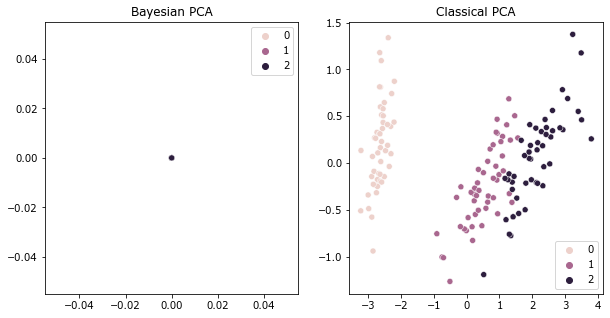

In [116]:

# Load the Iris dataset
iris = datasets.load_iris()
X = iris.data

# Standardize the features
scaler = StandardScaler()
#X = scaler.fit_transform(X)
X = X - np.mean(X, axis=0)

# Perform Bayesian PCA
q = X.shape[1] - 1
W_MP, sigma, alpha = Bayesian_PCA(X, q, num_epochs=1000)

print("W_MP=",np.shape(W_MP),"sigma=",sigma,"alpha=",alpha)

# Determine the effective dimension
alpha_sum = np.sum(1 / alpha)
effective_dimension = len(np.array([i for i, inv_alpha in enumerate(1 / alpha) if inv_alpha < alpha_sum / q]))
print(f"Effective dimension: {effective_dimension}")

# Project the data onto the latent space
E_x_n = project_to_latent_space(X, W_MP, sigma, alpha)

print("E_x_n=",np.shape(E_x_n))
# Perform classical PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot the projected data
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

sns.scatterplot(x=E_x_n[:, 0], y=E_x_n[:, 1], hue=iris.target, ax=ax[0])
ax[0].set_title('Bayesian PCA')

sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=iris.target, ax=ax[1])
ax[1].set_title('Classical PCA')

plt.show()


sigma= 0.5362078472718511
epoch =  0 sigma= -2.7407253817118944e-05 norm= 39.60492460386667
(64, 50) [[ 0.10559581 -1.09503913 -1.12301827 ...  0.87378431 -0.2194469
   0.88131398]
 [ 0.16904125 -1.53979574  1.02545237 ... -1.29473766  0.69256861
  -1.97485043]
 [ 1.28919533  0.63881039 -1.32963568 ...  0.73473082 -0.32328967
   0.23954097]
 ...
 [-0.37732114 -2.00777474 -0.82020002 ...  0.64222223  0.89795933
  -1.27874079]
 [ 0.47722486  0.51762679  1.27635637 ...  0.22408042  0.28449363
  -0.42417662]
 [-0.76756558 -2.24513029 -0.25086078 ... -0.18501572 -0.51413232
  -0.74341986]]
[2.20350213 2.28321817 1.38360096 2.23464606 2.25938159 2.04102363
 2.23438857 1.60138831 1.66431173 1.78658718 2.24245421 1.86292273
 2.18683692 1.55586513 1.7519483  1.72109302 1.91972008 1.7746
 1.70264626 2.16663188 1.8308654  2.15947382 2.67130293 1.87270452
 2.09707398 1.18786249 3.36552004 1.86717429 1.80606869 2.3916231
 1.94323611 2.66534282 2.48932827 1.96332155 2.37328917 1.85945939
 1.57795489

Text(0.5, 1.0, 'Classical PCA')

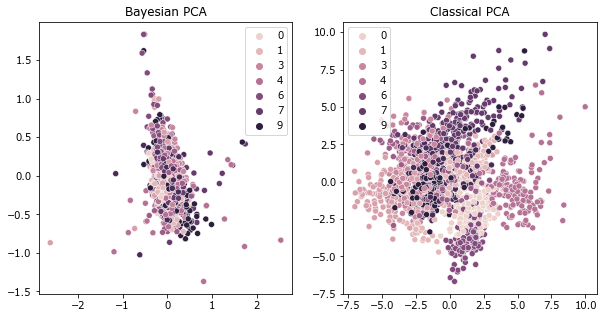

In [118]:
# do same for digits
digits = datasets.load_digits()
X = digits.data 
     
# Standardize the features
scaler = StandardScaler() 
X = scaler.fit_transform(X)
    
# Perform Bayesian PCA
W_MP, sigma, alpha = Bayesian_PCA(X, q=50, num_epochs=3)
    
# Determine the effective dimension
print(alpha)
effective_dimension = np.sum(alpha < 1e-6) 
print(f"Effective dimension: {effective_dimension}")
  
# Project the data onto the latent space 
E_x_n = project_to_latent_space(X, W_MP, sigma, alpha)
  
# Perform classical PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
 
# Plot the projected data 
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
 
sns.scatterplot(x=E_x_n[:, 0], y=E_x_n[:, 1], hue=digits.target, ax=ax[0])
ax[0].set_title('Bayesian PCA')
 
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=digits.target, ax=ax[1])
ax[1].set_title('Classical PCA')


W_MP=d,q

Xn=q,n

X=n,d

n,q * q,d * n,d

In [81]:
alpha

array([inf, inf, inf])